In [28]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

import backtrader as bt
import backtrader.analyzers as btanalyzers
import pandas as pd
import numpy as np
import pickle

In [29]:
def moving_average(x, w):
        moving_avg = np.convolve(x, np.ones(w), 'valid') / w
        padding = np.full_like(np.empty(w), np.nan)
        return np.insert(moving_avg, 0, padding)

def moving_avg_diff(short, long):
        return (short - long) / long


def get_X_y(df, binary_output=True):
    
    min_period = 30
    
    percent_change = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1)
    print(percent_change[:5])

    y = percent_change.copy()
    
    print(len(y))
    
    ## TEMP
    if binary_output == True:
        y = np.zeros(percent_change.shape)
        y[np.where(percent_change > 0)] = 1
    else:
        y = y.to_numpy()
    
    moving_average_1_day = moving_average(df["Close"], 1)
    moving_average_2_day = moving_average(df["Close"], 2)
    moving_average_3_day = moving_average(df["Close"], 3)
    moving_average_4_day = moving_average(df["Close"], 4)
    moving_average_5_day = moving_average(df["Close"], 5)
    moving_average_6_day = moving_average(df["Close"], 6)
    moving_average_7_day = moving_average(df["Close"], 7)
    moving_average_14_day = moving_average(df["Close"], 14)
    moving_average_30_day = moving_average(df["Close"], 30)
    
    mv_1d_2d = moving_avg_diff(moving_average_1_day, moving_average_2_day)
    mv_1d_3d = moving_avg_diff(moving_average_1_day, moving_average_3_day)
    mv_2d_4d = moving_avg_diff(moving_average_1_day, moving_average_3_day)
    mv_3d_7d = moving_avg_diff(moving_average_3_day, moving_average_7_day)
    mv_7d_14d = moving_avg_diff(moving_average_7_day, moving_average_14_day)
    mv_7d_30d = moving_avg_diff(moving_average_7_day, moving_average_30_day)
        
    X = np.stack((mv_1d_2d, mv_1d_3d, mv_3d_7d, mv_7d_14d, mv_7d_30d), axis=1)
    X = X[min_period:len(X)-1]
    y = y[min_period:]
    
    print(len(X), len(y))
    
    return (X, y)

In [30]:
df = pd.read_csv("../../data/clean/bitcoin_prices.csv")
df = df.iloc[::24, :]

df["Time"] = pd.to_datetime(df['Time'],unit='s')
df.set_index(pd.DatetimeIndex(df['Time']), inplace=True, drop=True)
start_date = datetime.datetime(2015,7,1)
df = df[df["Time"] > start_date]

offset = 30 # TODO: Refactor to output ox get_features
X, y = get_X_y(df)
df = df[offset:]
for i in range(0, len(X[0,:])):
    df["X_" + str(i)] = X[:,i]
df.describe()
print(df.columns)

Time
2015-07-20 21:00:00         NaN
2015-07-21 21:00:00    0.006691
2015-07-22 21:00:00   -0.009862
2015-07-23 21:00:00   -0.001444
2015-07-24 21:00:00    0.045501
Name: Close, dtype: float64
1988
1958 1958
Index(['Unnamed: 0', 'Time', 'Low', 'High', 'Open', 'Close', 'Volume', 'X_0',
       'X_1', 'X_2', 'X_3', 'X_4'],
      dtype='object')


In [31]:
class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

In [45]:
# Create a Stratey
class NNStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.X_0 = self.datas[0].X_0
        self.X_1 = self.datas[0].X_1
        self.X_2 = self.datas[0].X_2
        self.X_3 = self.datas[0].X_3
        self.X_4 = self.datas[0].X_4

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        filename = "../../models/pickles/neural_net_v2_daily_price"
        self.clf = pickle.load(open(filename, 'rb'))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            if order.status == order.Canceled:
                self.log("Order Cancelled")
            elif order.status == order.Margin:
                self.log("Order Margin")
            else:
                self.log("Order Rejected")
            self.log(order.status)

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
#         self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
    
        X = [[self.X_0[0], self.X_1[0], self.X_2[0], self.X_3[0], self.X_4[0]]]
        pred = self.clf.predict(X)[0]
#         if not self.position:
        print(pred, "no position", "new buy" if pred == 1 else "sit out")
        if pred == 1:
            self.log('BUY CREATE, %.2f' % self.dataclose[0])

            # Cancel existing orders 
            self.broker.cancel(self.order)

            self.buy(exectype=bt.Order.Market, size=(self.broker.get_cash() * 0.95 / self.data.close[0]))
                
        elif self.position and pred == 0:
            print(pred, "have active position", "sell")
            self.log('SELL CREATE, %.2f' % self.dataclose[0])
            size = self.broker.get_value() / self.dataclose[0]
            self.sell(size=self.position.size)
        else:
            print(pred, "have active position", "hold positition")

class PandasData(bt.feeds.PandasData):
    params = (
        ('X_0', 'X_0'),
        ('X_1', 'X_1'),
        ('X_2', 'X_2'),
        ('X_3', 'X_3'),
        ('X_4', 'X_4'),
    )
    lines = ('X_0','X_1', 'X_2', 'X_3', 'X_4')

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(NNStrategy)

    data = PandasData(dataname=df)
    cerebro.adddata(data)

    cerebro.broker.setcash(10000)

    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    cerebro.broker.addcommissioninfo(CommInfoFractional())
    
    ## Include commission to see algo's returns with Coinbase Fees
#     cerebro.broker.setcommission(commission=0.001, margin=None) 
    
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='annualreturn')
    cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(btanalyzers.Returns, _name='returns')
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='tradeanalyzer')

    cerebro.addobserver(bt.observers.DrawDown)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    strats = cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
1.0 no position new buy
2015-08-19, BUY CREATE, 225.64
2015-08-20, BUY EXECUTED, Price: 236.72, Cost: 9966.50, Comm 0.00
1.0 no position new buy
2015-08-20, BUY CREATE, 236.68
2015-08-21, BUY EXECUTED, Price: 233.63, Cost: 31.42, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2015-08-21, SELL CREATE, 233.30
2015-08-22, SELL EXECUTED, Price: 228.10, Cost: 9997.91, Comm 0.00
2015-08-22, OPERATION PROFIT, GROSS -363.67, NET -363.67
0.0 no position sit out
0.0 have active position hold positition
1.0 no position new buy
2015-08-23, BUY CREATE, 228.16
2015-08-24, BUY EXECUTED, Price: 215.54, Cost: 8648.16, Comm 0.00
1.0 no position new buy
2015-08-24, BUY CREATE, 210.48
2015-08-25, Order Margin
2015-08-25, 7
1.0 no position new buy
2015-08-25, BUY CREATE, 223.55
2015-08-26, BUY EXECUTED, Price: 227.69, Cost: 956.15, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2015-08-26, SELL CREATE, 227.58
2015-08-27, SELL EXECUTED, Pr

2016-02-03, BUY EXECUTED, Price: 369.57, Cost: 12593.32, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2016-02-03, SELL CREATE, 368.59
2016-02-04, SELL EXECUTED, Price: 389.46, Cost: 12593.32, Comm 0.00
2016-02-04, OPERATION PROFIT, GROSS 677.76, NET 677.76
1.0 no position new buy
2016-02-04, BUY CREATE, 386.64
2016-02-05, BUY EXECUTED, Price: 385.12, Cost: 13317.53, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2016-02-05, SELL CREATE, 384.56
2016-02-06, SELL EXECUTED, Price: 374.43, Cost: 13317.53, Comm 0.00
2016-02-06, OPERATION PROFIT, GROSS -369.66, NET -369.66
0.0 no position sit out
0.0 have active position hold positition
1.0 no position new buy
2016-02-07, BUY CREATE, 376.10
2016-02-08, BUY EXECUTED, Price: 371.13, Cost: 12846.87, Comm 0.00
1.0 no position new buy
2016-02-08, BUY CREATE, 371.69
2016-02-09, BUY EXECUTED, Price: 372.10, Cost: 815.28, Comm 0.00
1.0 no position new buy
2016-02-09, BUY CREATE, 372.10
2016-02-10, BUY EXECUTED, Pri

1.0 no position new buy
2016-06-11, BUY CREATE, 586.70
2016-06-12, Order Margin
2016-06-12, 7
1.0 no position new buy
2016-06-12, BUY CREATE, 675.36
2016-06-13, BUY EXECUTED, Price: 690.00, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-06-13, BUY CREATE, 702.51
2016-06-14, BUY EXECUTED, Price: 688.97, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-06-14, BUY CREATE, 686.42
2016-06-15, BUY EXECUTED, Price: 694.16, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-06-15, BUY CREATE, 692.81
2016-06-16, Order Margin
2016-06-16, 7
1.0 no position new buy
2016-06-16, BUY CREATE, 774.68
2016-06-17, BUY EXECUTED, Price: 758.93, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-06-17, BUY CREATE, 749.98
2016-06-18, BUY EXECUTED, Price: 755.07, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-06-18, BUY CREATE, 755.58
2016-06-19, BUY EXECUTED, Price: 766.00, Cost: 0.00, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2016-06-19, SELL CREATE, 766.85
2016-06-20, SELL E

1.0 no position new buy
2016-11-14, BUY CREATE, 706.77
2016-11-15, BUY EXECUTED, Price: 714.71, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-11-15, BUY CREATE, 710.14
2016-11-16, BUY EXECUTED, Price: 735.08, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-11-16, BUY CREATE, 737.64
2016-11-17, BUY EXECUTED, Price: 741.29, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-11-17, BUY CREATE, 739.01
2016-11-18, BUY EXECUTED, Price: 743.99, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-11-18, BUY CREATE, 742.50
2016-11-19, BUY EXECUTED, Price: 748.19, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-11-19, BUY CREATE, 748.98
2016-11-20, BUY EXECUTED, Price: 727.98, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-11-20, BUY CREATE, 727.42
2016-11-21, BUY EXECUTED, Price: 736.58, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-11-21, BUY CREATE, 735.94
2016-11-22, BUY EXECUTED, Price: 747.60, Cost: 0.00, Comm 0.00
1.0 no position new buy
2016-11-22, BUY CREATE, 747.43
2

2017-03-10, BUY CREATE, 1104.25
2017-03-11, Order Margin
2017-03-11, 7
1.0 no position new buy
2017-03-11, BUY CREATE, 1178.41
2017-03-12, BUY EXECUTED, Price: 1231.87, Cost: 0.00, Comm 0.00
1.0 no position new buy
2017-03-12, BUY CREATE, 1240.00
2017-03-13, BUY EXECUTED, Price: 1247.00, Cost: 0.00, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2017-03-13, SELL CREATE, 1244.83
2017-03-14, SELL EXECUTED, Price: 1253.99, Cost: 30113.73, Comm 0.00
2017-03-14, OPERATION PROFIT, GROSS 7106.16, NET 7106.16
1.0 no position new buy
2017-03-14, BUY CREATE, 1247.81
2017-03-15, BUY EXECUTED, Price: 1252.59, Cost: 35494.35, Comm 0.00
1.0 no position new buy
2017-03-15, BUY CREATE, 1256.09
2017-03-16, BUY EXECUTED, Price: 1153.65, Cost: 1505.58, Comm 0.00
1.0 no position new buy
2017-03-16, BUY CREATE, 1166.17
2017-03-17, BUY EXECUTED, Price: 1109.56, Cost: 198.82, Comm 0.00
1.0 no position new buy
2017-03-17, BUY CREATE, 1109.95
2017-03-18, BUY EXECUTED, Price: 947.02, Cost: 17.1

2017-07-29, SELL EXECUTED, Price: 2728.16, Cost: 79697.27, Comm 0.00
2017-07-29, OPERATION PROFIT, GROSS -1705.17, NET -1705.17
0.0 no position sit out
0.0 have active position hold positition
1.0 no position new buy
2017-07-30, BUY CREATE, 2726.36
2017-07-31, Order Margin
2017-07-31, 7
1.0 no position new buy
2017-07-31, BUY CREATE, 2866.25
2017-08-01, BUY EXECUTED, Price: 2746.43, Cost: 70995.18, Comm 0.00
1.0 no position new buy
2017-08-01, BUY CREATE, 2725.99
2017-08-02, BUY EXECUTED, Price: 2689.50, Cost: 6558.13, Comm 0.00
1.0 no position new buy
2017-08-02, BUY CREATE, 2664.24
2017-08-03, BUY EXECUTED, Price: 2780.00, Cost: 435.00, Comm 0.00
1.0 no position new buy
2017-08-03, BUY CREATE, 2779.99
2017-08-04, BUY EXECUTED, Price: 2832.00, Cost: 3.70, Comm 0.00
1.0 no position new buy
2017-08-04, BUY CREATE, 2839.00
2017-08-05, Order Margin
2017-08-05, 7
1.0 no position new buy
2017-08-05, BUY CREATE, 3215.97
2017-08-06, BUY EXECUTED, Price: 3264.54, Cost: 0.12, Comm 0.00
1.0 no p

0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position 

1.0 no position new buy
2018-04-27, BUY CREATE, 8980.99
2018-04-28, BUY EXECUTED, Price: 9320.31, Cost: 0.00, Comm 0.00
1.0 no position new buy
2018-04-28, BUY CREATE, 9259.00
2018-04-29, BUY EXECUTED, Price: 9294.14, Cost: 0.00, Comm 0.00
1.0 no position new buy
2018-04-29, BUY CREATE, 9316.00
2018-04-30, BUY EXECUTED, Price: 9272.40, Cost: 0.00, Comm 0.00
1.0 no position new buy
2018-04-30, BUY CREATE, 9210.00
2018-05-01, BUY EXECUTED, Price: 9014.00, Cost: 0.00, Comm 0.00
1.0 no position new buy
2018-05-01, BUY CREATE, 9075.11
2018-05-02, BUY EXECUTED, Price: 9176.00, Cost: 0.00, Comm 0.00
1.0 no position new buy
2018-05-02, BUY CREATE, 9226.01
2018-05-03, BUY EXECUTED, Price: 9639.75, Cost: 0.00, Comm 0.00
1.0 no position new buy
2018-05-03, BUY CREATE, 9636.94
2018-05-04, BUY EXECUTED, Price: 9684.89, Cost: 0.00, Comm 0.00
1.0 no position new buy
2018-05-04, BUY CREATE, 9701.00
2018-05-05, BUY EXECUTED, Price: 9720.00, Cost: 0.00, Comm 0.00
1.0 no position new buy
2018-05-05, BUY 

2018-08-17, BUY CREATE, 6523.00
2018-08-18, BUY EXECUTED, Price: 6370.00, Cost: 222874.02, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2018-08-18, SELL CREATE, 6399.37
2018-08-19, SELL EXECUTED, Price: 6534.00, Cost: 222874.02, Comm 0.00
2018-08-19, OPERATION PROFIT, GROSS 5738.04, NET 5738.04
1.0 no position new buy
2018-08-19, BUY CREATE, 6501.01
2018-08-20, BUY EXECUTED, Price: 6456.29, Cost: 232070.88, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2018-08-20, SELL CREATE, 6415.01
2018-08-21, SELL EXECUTED, Price: 6444.69, Cost: 232070.88, Comm 0.00
2018-08-21, OPERATION PROFIT, GROSS -416.96, NET -416.96
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit o

2019-01-14, BUY EXECUTED, Price: 3671.47, Cost: 0.00, Comm 0.00
1.0 no position new buy
2019-01-14, BUY CREATE, 3665.87
2019-01-15, BUY EXECUTED, Price: 3565.67, Cost: 0.00, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2019-01-15, SELL CREATE, 3568.48
2019-01-16, SELL EXECUTED, Price: 3590.01, Cost: 150579.81, Comm 0.00
2019-01-16, OPERATION PROFIT, GROSS -3800.17, NET -3800.17
1.0 no position new buy
2019-01-16, BUY CREATE, 3602.48
2019-01-17, BUY EXECUTED, Price: 3627.09, Cost: 140393.23, Comm 0.00
1.0 no position new buy
2019-01-17, BUY CREATE, 3626.10
2019-01-18, BUY EXECUTED, Price: 3606.71, Cost: 6034.64, Comm 0.00
1.0 no position new buy
2019-01-18, BUY CREATE, 3612.17
2019-01-19, BUY EXECUTED, Price: 3703.46, Cost: 342.62, Comm 0.00
1.0 no position new buy
2019-01-19, BUY CREATE, 3702.92
2019-01-20, BUY EXECUTED, Price: 3533.77, Cost: 8.29, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2019-01-20, SELL CREATE, 3539.21
2019-01-21, SELL EXECUT

0.0 no position sit out
0.0 have active position hold positition
1.0 no position new buy
2019-05-21, BUY CREATE, 8001.61
2019-05-22, BUY EXECUTED, Price: 7827.01, Cost: 262724.70, Comm 0.00
1.0 no position new buy
2019-05-22, BUY CREATE, 7672.29
2019-05-23, BUY EXECUTED, Price: 7881.52, Cost: 19514.99, Comm 0.00
1.0 no position new buy
2019-05-23, BUY CREATE, 7919.66
2019-05-24, BUY EXECUTED, Price: 8109.53, Cost: 468.66, Comm 0.00
1.0 no position new buy
2019-05-24, BUY CREATE, 8058.30
2019-05-25, BUY EXECUTED, Price: 8044.79, Cost: 12.44, Comm 0.00
1.0 no position new buy
2019-05-25, BUY CREATE, 8051.89
2019-05-26, Order Margin
2019-05-26, 7
1.0 no position new buy
2019-05-26, BUY CREATE, 8640.60
2019-05-27, BUY EXECUTED, Price: 8755.98, Cost: 0.65, Comm 0.00
1.0 no position new buy
2019-05-27, BUY CREATE, 8813.42
2019-05-28, BUY EXECUTED, Price: 8686.95, Cost: 0.02, Comm 0.00
1.0 no position new buy
2019-05-28, BUY CREATE, 8714.10
2019-05-29, BUY EXECUTED, Price: 8647.12, Cost: 0.00

1.0 no position new buy
2019-10-05, BUY CREATE, 8163.54
2019-10-06, BUY EXECUTED, Price: 7906.98, Cost: 0.10, Comm 0.00
1.0 no position new buy
2019-10-06, BUY CREATE, 7926.98
2019-10-07, BUY EXECUTED, Price: 8215.59, Cost: 0.01, Comm 0.00
1.0 no position new buy
2019-10-07, BUY CREATE, 8209.39
2019-10-08, BUY EXECUTED, Price: 8131.00, Cost: 0.00, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2019-10-08, SELL CREATE, 8164.90
2019-10-09, SELL EXECUTED, Price: 8587.99, Cost: 244736.27, Comm 0.00
2019-10-09, OPERATION PROFIT, GROSS 6355.90, NET 6355.90
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
0.0 no position sit out
0.0 have active position hold positition
1.0 no position new buy
2019-10-12, BUY CREATE, 8340.00
2019-10-13, BUY EXECUTED, Price: 8263.26, Cost: 236342.68, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2019-10-13, SELL CREATE, 8251.39
2019-10-14, SELL EX

2020-02-15, BUY EXECUTED, Price: 9892.01, Cost: 0.00, Comm 0.00
1.0 no position new buy
2020-02-15, BUY CREATE, 9924.41
2020-02-16, BUY EXECUTED, Price: 9780.01, Cost: 0.00, Comm 0.00
1.0 no position new buy
2020-02-16, BUY CREATE, 9768.01
2020-02-17, BUY EXECUTED, Price: 9632.61, Cost: 0.00, Comm 0.00
1.0 no position new buy
2020-02-17, BUY CREATE, 9646.02
2020-02-18, Order Margin
2020-02-18, 7
1.0 no position new buy
2020-02-18, BUY CREATE, 10171.40
2020-02-19, BUY EXECUTED, Price: 10166.94, Cost: 0.00, Comm 0.00
1.0 no position new buy
2020-02-19, BUY CREATE, 9625.42
2020-02-20, BUY EXECUTED, Price: 9588.58, Cost: 0.00, Comm 0.00
1.0 no position new buy
2020-02-20, BUY CREATE, 9608.11
2020-02-21, BUY EXECUTED, Price: 9712.59, Cost: 0.00, Comm 0.00
1.0 no position new buy
2020-02-21, BUY CREATE, 9675.20
2020-02-22, BUY EXECUTED, Price: 9700.01, Cost: 0.00, Comm 0.00
1.0 no position new buy
2020-02-22, BUY CREATE, 9695.84
2020-02-23, BUY EXECUTED, Price: 9890.88, Cost: 0.00, Comm 0.00

1.0 no position new buy
2020-06-04, BUY CREATE, 9784.44
2020-06-05, BUY EXECUTED, Price: 9713.66, Cost: 8731.72, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2020-06-05, SELL CREATE, 9664.20
2020-06-06, SELL EXECUTED, Price: 9708.50, Cost: 309261.71, Comm 0.00
2020-06-06, OPERATION PROFIT, GROSS -2382.24, NET -2382.24
1.0 no position new buy
2020-06-06, BUY CREATE, 9697.40
2020-06-07, BUY EXECUTED, Price: 9736.21, Cost: 293204.46, Comm 0.00
1.0 no position new buy
2020-06-07, BUY CREATE, 9709.99
2020-06-08, BUY EXECUTED, Price: 9702.00, Cost: 13480.36, Comm 0.00
1.0 no position new buy
2020-06-08, BUY CREATE, 9719.62
2020-06-09, BUY EXECUTED, Price: 9750.01, Cost: 687.26, Comm 0.00
1.0 no position new buy
2020-06-09, BUY CREATE, 9821.96
2020-06-10, BUY EXECUTED, Price: 9865.95, Cost: 32.37, Comm 0.00
1.0 no position new buy
2020-06-10, BUY CREATE, 9856.11
2020-06-11, BUY EXECUTED, Price: 9338.43, Cost: 1.40, Comm 0.00
1.0 no position new buy
2020-06-11, BUY CREATE, 9

2020-09-30, SELL EXECUTED, Price: 10704.49, Cost: 364074.68, Comm 0.00
2020-09-30, OPERATION PROFIT, GROSS -5329.79, NET -5329.79
1.0 no position new buy
2020-09-30, BUY CREATE, 10707.38
2020-10-01, BUY EXECUTED, Price: 10606.76, Cost: 338390.28, Comm 0.00
1.0 no position new buy
2020-10-01, BUY CREATE, 10581.90
2020-10-02, BUY EXECUTED, Price: 10546.09, Cost: 20061.50, Comm 0.00
1.0 no position new buy
2020-10-02, BUY CREATE, 10472.06
2020-10-03, BUY EXECUTED, Price: 10572.03, Cost: 1081.42, Comm 0.00
1.0 no position new buy
2020-10-03, BUY CREATE, 10578.61
2020-10-04, BUY EXECUTED, Price: 10646.87, Cost: 44.13, Comm 0.00
1.0 no position new buy
2020-10-04, BUY CREATE, 10647.10
2020-10-05, BUY EXECUTED, Price: 10742.68, Cost: 1.94, Comm 0.00
0.0 no position sit out
0.0 have active position sell
2020-10-05, SELL CREATE, 10742.05
2020-10-06, SELL EXECUTED, Price: 10545.20, Cost: 359579.27, Comm 0.00
2020-10-06, OPERATION PROFIT, GROSS -1968.86, NET -1968.86
0.0 no position sit out
0.0 h

2020-12-15, BUY EXECUTED, Price: 19501.45, Cost: 0.00, Comm 0.00
1.0 no position new buy
2020-12-15, BUY CREATE, 19429.20
2020-12-16, Order Margin
2020-12-16, 7
1.0 no position new buy
2020-12-16, BUY CREATE, 21209.87
2020-12-17, Order Margin
2020-12-17, 7
0.0 no position sit out
0.0 have active position sell
2020-12-17, SELL CREATE, 22790.14
2020-12-18, SELL EXECUTED, Price: 22787.07, Cost: 373031.17, Comm 0.00
2020-12-18, OPERATION PROFIT, GROSS 370385.66, NET 370385.66
0.0 no position sit out
0.0 have active position hold positition
1.0 no position new buy
2020-12-19, BUY CREATE, 23994.59
2020-12-20, BUY EXECUTED, Price: 24188.59, Cost: 711956.10, Comm 0.00
1.0 no position new buy
2020-12-20, BUY CREATE, 23384.92
2020-12-21, BUY EXECUTED, Price: 22842.40, Cost: 29194.31, Comm 0.00
1.0 no position new buy
2020-12-21, BUY CREATE, 23149.95
2020-12-22, BUY EXECUTED, Price: 23436.72, Cost: 2179.77, Comm 0.00
1.0 no position new buy
2020-12-22, BUY CREATE, 23440.90
2020-12-23, BUY EXECUTE

In [46]:
print('Returns:', strats[0].analyzers.returns.pprint())
print('Sharpe Ratio:', strats[0].analyzers.mysharpe.pprint())
print('Annual Return:', strats[0].analyzers.annualreturn.pprint())
print('Drawdown:', strats[0].analyzers.drawdown.pprint())
print('Trade Analyzer:', strats[0].analyzers.tradeanalyzer.pprint())

OrderedDict([('rtot', 4.398144754283419),
             ('ravg', 0.0022462434904409697),
             ('rnorm', 0.7613020903737462),
             ('rnorm100', 76.13020903737461)])
Returns: None
OrderedDict([('sharperatio', 0.6527473352579092)])
Sharpe Ratio: None
OrderedDict([(2015, 0.7892505906932037),
             (2016, 0.705042203746828),
             (2017, 9.885689271176869),
             (2018, -0.5474848725957849),
             (2019, 0.682673557939357),
             (2020, 2.2151022496063693)])
Annual Return: None
AutoOrderedDict([('len', 1),
                 ('drawdown', 1.1325813232394333),
                 ('moneydown', 9313.355864186888),
                 ('max',
                  AutoOrderedDict([('len', 546),
                                   ('drawdown', 64.41595413621899),
                                   ('moneydown', 250216.90652301445)]))])
Drawdown: None
AutoOrderedDict([('total',
                  AutoOrderedDict([('total', 208),
                                

<IPython.core.display.Javascript object>


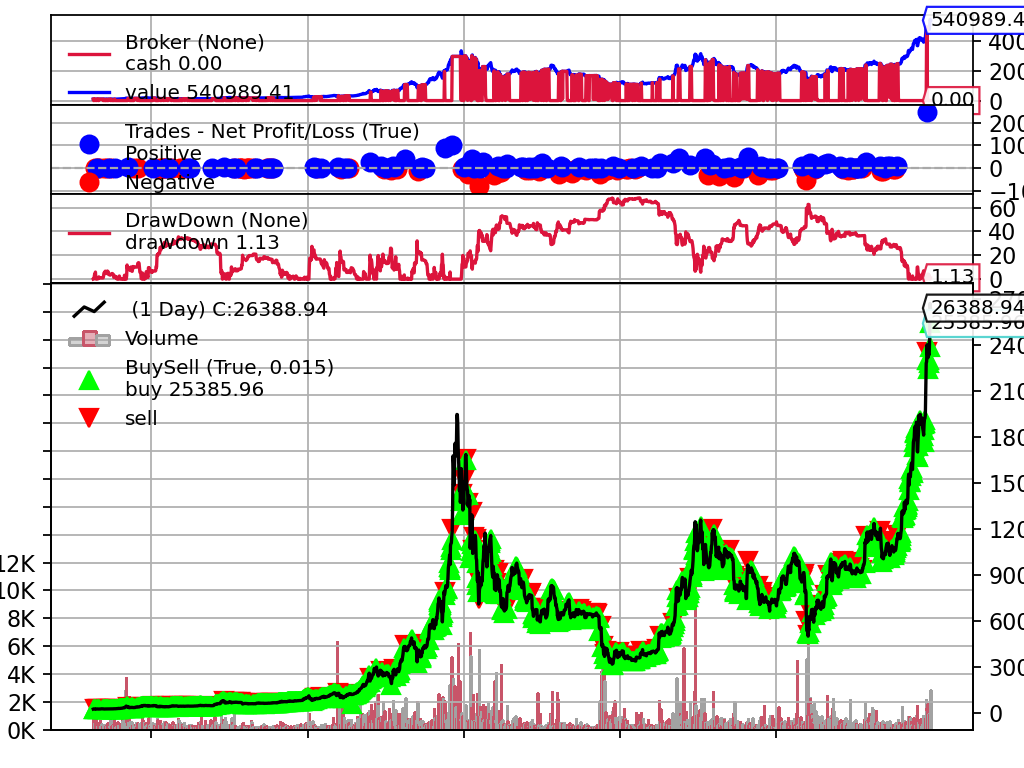

[[<Figure size 640x480 with 5 Axes>]]

In [44]:
cerebro.plot()